In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

--2022-09-20 09:25:45--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  14.4MB/s    in 2m 15s  

2022-09-20 09:28:01 (14.1 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [ ]:
!tar -xvf VOCtrainval_11-May-2012.tar

ストリーミング出力は最後の 5000 行に切り捨てられました。
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC2012/SegmentationCl

# ここからセマンティックセグメンテーションの練習

In [ ]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 6.4 MB/s 
     |████████████████████████████████| 376 kB 60.4 MB/s 
     |████████████████████████████████| 58 kB 3.3 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=4264a5fe83a2974f1b3b4e76155ff3100c40436a3f391f0ace33acfb9e3b3239
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=9be901ce53bc99c3fa9023e1a7cce1c52d40f61efa8f08b948d0350af9b0b4c3
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
!nvidia-smi

Tue Sep 20 09:28:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# ライブラリ読み込み
import glob
import cv2
import numpy as np
import os

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as utils


import albumentations as albu
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image,ImageFile


In [ ]:
#VOC2012で用いるラベルに関する固定値を宣言

CLASSES = ['backgrounds','aeroplane','bicycle','bird','boat','bottle',
                           'bus','car' ,'cat','chair','cow', 
                           'diningtable','dog','horse','motorbike','person', 
                           'potted plant', 'sheep', 'sofa', 'train', 'monitor','unlabeld'
                           ]

#読み込んだマスク画像は(H,W)。RGB情報はカラーパレットに入っているため、1ピクセル＝１インデックス対応
COLOR_PALETTE = np.array(Image.open("./VOCdevkit/VOC2012/SegmentationClass/2007_000170.png").getpalette()).reshape(-1,3)
COLOR_PALETTE = COLOR_PALETTE.tolist()[:len(CLASSES)]


IMAGE_SIZE = 256

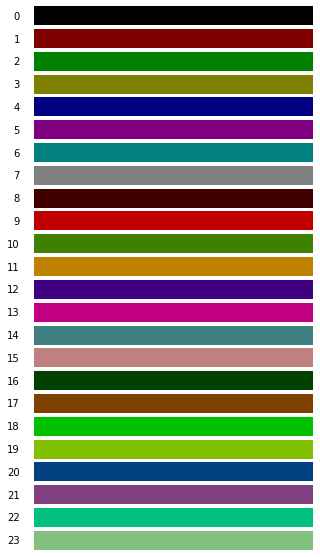

In [ ]:
#color_pallete確認
tmp_color_pallete = Image.open("./VOCdevkit/VOC2012/SegmentationClass/2007_000170.png").getpalette()
tmp_color_pallete = np.array(tmp_color_pallete).reshape(-1, 3)


# 256個のうち、25個を表示
fig, axes_list = plt.subplots(24, 1, figsize=(5, 10))
for i, color in enumerate(tmp_color_pallete[:24]):
    color_img = np.full((1, 10, 3), color, dtype=np.uint8)

    axes_list[i].imshow(color_img, aspect='auto')
    axes_list[i].set_axis_off()
    axes_list[i].text(-1, 0, i, va='center', ha='right', fontsize=10)
    
plt.show()



#####################
#下記パレットを見ると15番：人はピンクで表現されることがわかる
#####################

In [ ]:
def segmentation2mask(mask):
    # onehotベクトルからカラーインデックスを取り出して、該当するRGB3次元を付与
    # mask.shape = (H,W,label_onehot)
    tmp_mask = np.asarray(mask)
    H,W = mask.shape[:2]
    img = [[0 for j in range(W)] for i in range(H)]

    for height in range(H):
        for width in range(W):
            index = np.argmax(mask[height,width,:])
            rgb = COLOR_PALETTE[index]
            img[height][width] = rgb
    print(np.asarray(img).shape)
    return np.asarray(img)





# データ確認用

def visualize(image,mask,predict_mask=None):
    plt.figure(figsize=(20, 5))
    plt.subplot(1,3,1)
    plt.xticks([])
    plt.yticks([])
    plt.title(' images ')
    plt.imshow(image)

    plt.subplot(1,3,2)
    plt.xticks([])
    plt.yticks([])
    plt.title(' mask ')
    plt.imshow(segmentation2mask(mask))

    if predict_mask is not  None:
      plt.subplot(1,3,3)
      plt.xticks([])
      plt.yticks([])
      plt.title(' predict ')
      plt.imshow(segmentation2mask(predict_mask))

    plt.show()

In [ ]:
# データ拡張
def get_training_augmentation():
    #albumentationsを用いたデータ拡張はコチラ
    
    train_transform = [
            albu.HorizontalFlip(p=0.5),
            albu.Rotate(p=0.5,limit=(-30,30)),
            albu.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, p=0.5),
            albu.Resize(256,256),
          
        ]
    return albu.Compose(train_transform)

In [ ]:
# テンソル化
def to_tensor(x, **kwargs):
    return x.transpose(2, 1, 0).astype('float32')

def to_norm(x ,  **kwargs):
    return  x/255

# 前処理
def get_preprocessing(preprocessing_fn):
    # train/testに関わらず加えるデータ加工
    if preprocessing_fn == None:
      _transform = [
            albu.Lambda(image=to_norm),
            albu.Resize(256,256),
            albu.Lambda(image=to_tensor, mask=to_tensor),
        ]
    else:
      _transform = [
              albu.Lambda(image=preprocessing_fn),
              albu.Resize(256,256),
              albu.Lambda(image=to_tensor, mask=to_tensor),
          ]
    return albu.Compose(_transform)

In [ ]:
# データセット
class Dataset(BaseDataset):
    
    def __init__(
            self,
            ids,
            images_dir,
            masks_dir,
            augmentation=None,
            preprocessing=None,
            
    ):
        self.ids = ids
        self.images_fps = [os.path.join(images_dir, image_id)+".jpg" for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id)+".png" for image_id in self.ids]
        self.CLASSES = CLASSES

        
        # クラスに対応した数字配列を用意
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in self.CLASSES]
        
        

        self.augmentation = augmentation #呼び出し時に引数に何も入れなければ、Noneが格納されて、後ろのif分岐に入らなくなる
        self.preprocessing = preprocessing
        self.Onehot = True


    


    def __getitem__(self, i):
        # read data
        #image = cv2.imread(self.images_fps[i])
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.asarray(Image.open(self.images_fps[i]))


        mask = Image.open(self.masks_fps[i])
        mask = np.asarray(mask)
        mask = np.where(mask == 255, len(self.CLASSES), mask)  # unlabeledのパレットインデックスを255番から最後番(今回は22番)に変更
        
       
        #onehotベクトルに変換
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        
            
        return image, mask

    def __len__(self):
        return len(self.ids)

# お試しでDatasetクラスから画像を一枚取り出す

In [ ]:
image_dir = r'./VOCdevkit/VOC2012/JPEGImages'
mask_dir = r'./VOCdevkit/VOC2012/SegmentationClass' 

#train/validation の写真IDを載せる
df_train = pd.read_table(r'./VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt',header=None)
df_valid = pd.read_table(r'./VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt',header=None)
df_train.columns = ['image_id'] 
df_valid.columns = ['image_id']

training_images = df_train.image_id.values
validation_images = df_valid.image_id.values
training_images = df_train.sort_values('image_id').image_id.values
validation_images = df_valid.sort_values('image_id').image_id.values



mask.shape:(375, 500, 22)
(375, 500, 3)


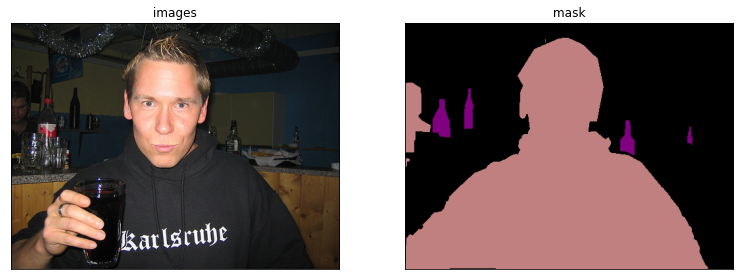

[ 0  5 15]


In [ ]:
# データ確認のためにお試しでDatasetインスタンスを作成
dataset = Dataset(training_images,image_dir,mask_dir)


image, mask = dataset[5] # get some sample
print("mask.shape:{}".format(mask.shape))
visualize(
    image=image, 
    mask=mask.squeeze()
)
print(np.unique(np.asarray(np.argmax(mask,axis=2).reshape(-1))))#人画像の時に出現するindex->[  0   5  15]

# 学習モデル宣言

In [ ]:
# モデルを宣言
ENCODER = 'efficientnet-b3'
#公式github参照 https://github.com/qubvel/segmentation_models.pytorch
ENCODER_WEIGHTS = 'imagenet'


#シングルクラスの場合は"sigmoid"等,
#softmax2dは(N,C,H,W)のCの次元に対してsoftmax計算してくれる。
ACTIVATION = "softmax2d"  # could be None for logits or 'softmax2d' for multicalss segmentation 
DEVICE = 'cuda' if torch.cuda.is_available()  else "cpu"

DECODER = "DeepLabV3Plus"
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

model = model.to(DEVICE)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

In [ ]:
preprocessing_fn =smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)#事前学習済みモデルと同じ加工を自動選択
#preprocessing_fn = None　#事前学習済みモデルと同じ加工が不要な場合コチラを採用


# データセットを作成
train_dataset = Dataset(
    training_images,
    image_dir,
    mask_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)
valid_dataset = Dataset(
    validation_images,
    image_dir,
    mask_dir,
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2) #仮にwindows環境で動かす場合はnum_workers=0にする
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
# 精度確認指標
metrics = [
    utils.metrics.IoU(threshold=0.5),
]
# loss  #mode='multilabel'は1枚画像の中に複数種類の物体が存在するときに使う
loss = smp.losses.DiceLoss(mode='multilabel')
loss.__name__ = 'dice_loss'
#loss = smp.losses.FocalLoss(mode='multilabel')
#loss.__name__ = 'focal_loss'

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),#あまりにここが大きいと全て0、学習に失敗します。
])


In [ ]:
# 1Epochトレイン用
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

# train_loaderの中身(データ拡張後画像)を確認する

correct_color_index:[0 8]
predict_color_index:[0 8]
(256, 256, 3)


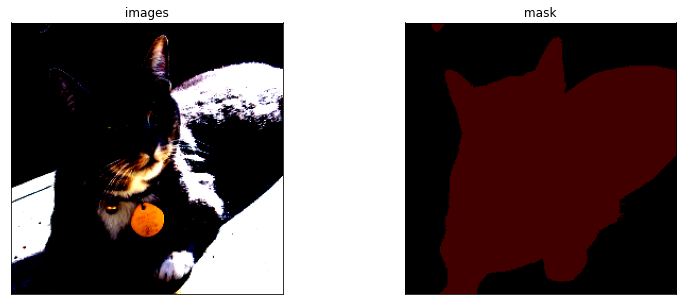

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0  8 20]
predict_color_index:[ 0  8 20]


(256, 256, 3)


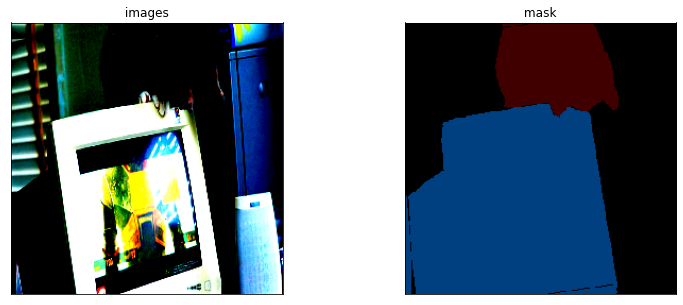

--------------------------------------------------------
--------------------------------------------------------


correct_color_index:[ 0  4  7 15]
predict_color_index:[ 0  4  7 15]
(256, 256, 3)


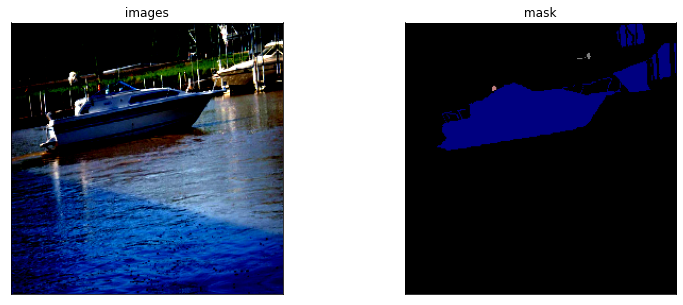

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0 13]
predict_color_index:[ 0 13]


(256, 256, 3)


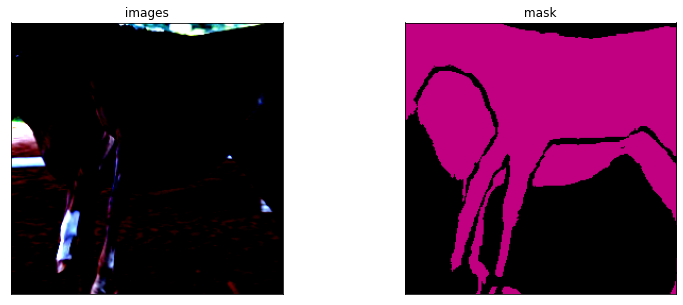

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0 14 15]
predict_color_index:[ 0 14 15]
(256, 256, 3)


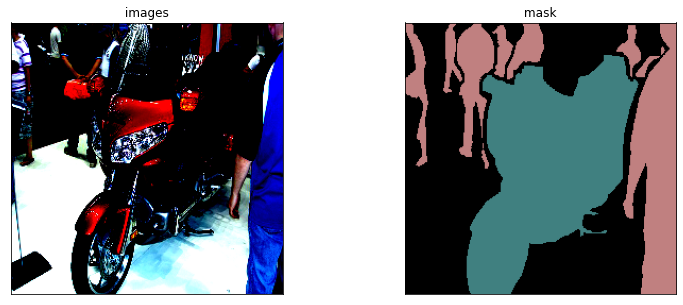

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0 19]
predict_color_index:[ 0 19]
(256, 256, 3)


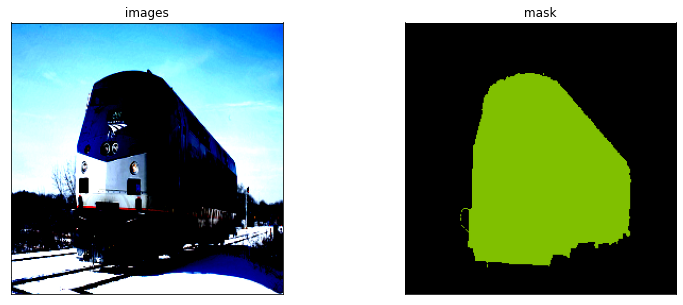

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0  7  9 15]
predict_color_index:[ 0  7  9 15]


(256, 256, 3)


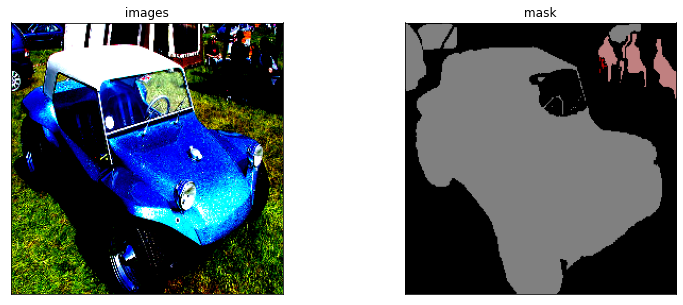

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[0 1]
predict_color_index:[0 1]
(256, 256, 3)


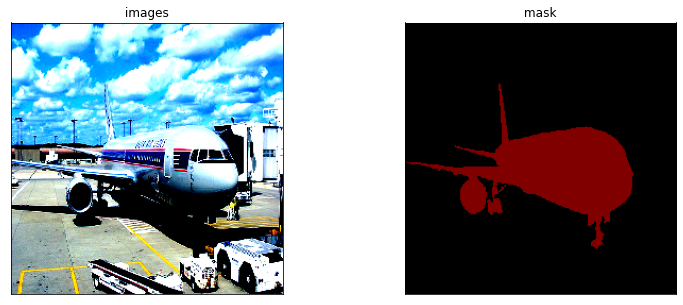

--------------------------------------------------------
--------------------------------------------------------


In [ ]:
for i , (images, label) in enumerate(train_loader):
  batch_size=images.shape[0]

  
  #今回は1バッチのみplotしてみる
  for j in range(images.shape[0]//4):

    reshape_label = torch.argmax(label[j],axis=0)
    

    tmp = torch.argmax(label[j],axis=0)
    
    reshape_tmp = tmp.cpu()
    print("correct_color_index:{}".format(np.unique(np.asarray(reshape_label.reshape(-1)))))
    print("predict_color_index:{}".format(np.unique(np.asarray(reshape_tmp.reshape(-1)))))

    #バッチサイズの中身毎に描画
    visualize(
      image=images[j].transpose(2,0), 
      mask=label[j].cpu().transpose(2,0).detach().numpy()
    )
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
  break

In [ ]:

# 学習 
max_score = 0
for i in range(0, 30):

    print('\nEpoch: {}'.format(i))
    try:
        train_logs = train_epoch.run(train_loader)
        val_logs = valid_epoch.run(valid_loader)
        print(val_logs)
    except Exception as e:
        print(e)

    # do something (save model, change lr, etc.)
    if max_score < val_logs['iou_score']:
        max_score = val_logs['iou_score']
        torch.save(model, f'{DECODER}_{ENCODER}.pth')
        print('Model saved!')



Epoch: 0
valid: 100%|██████████| 46/46 [01:29<00:00,  1.94s/it, dice_loss - 0.7562, iou_score - 0.05912]
{'dice_loss': 0.7562225260164426, 'iou_score': 0.059122102294603116}
Model saved!

Epoch: 1
valid: 100%|██████████| 46/46 [01:27<00:00,  1.91s/it, dice_loss - 0.7514, iou_score - 0.553]
{'dice_loss': 0.7513724805220312, 'iou_score': 0.5529652905205021}
Model saved!

Epoch: 2
valid: 100%|██████████| 46/46 [01:27<00:00,  1.90s/it, dice_loss - 0.7504, iou_score - 0.6146]
{'dice_loss': 0.7503532968137575, 'iou_score': 0.6145848139472629}
Model saved!

Epoch: 3
valid: 100%|██████████| 46/46 [01:26<00:00,  1.88s/it, dice_loss - 0.7497, iou_score - 0.6393]
{'dice_loss': 0.7496561939301699, 'iou_score': 0.6392829780993252}
Model saved!

Epoch: 4
valid: 100%|██████████| 46/46 [01:26<00:00,  1.88s/it, dice_loss - 0.749, iou_score - 0.6509]
{'dice_loss': 0.7490032438350762, 'iou_score': 0.6508505551711373}
Model saved!

Epoch: 5
valid: 100%|██████████| 46/46 [01:27<00:00,  1.90s/it, dice_loss

# 保存した最高精度のモデルを呼び出し

In [ ]:
predict_model = torch.load(f'{DECODER}_{ENCODER}.pth')

# 予測したモデルを用いてマスク画像を予測する

correct_color_index:[0 1]
predict_color_index:[0 1]
(256, 256, 3)
(256, 256, 3)


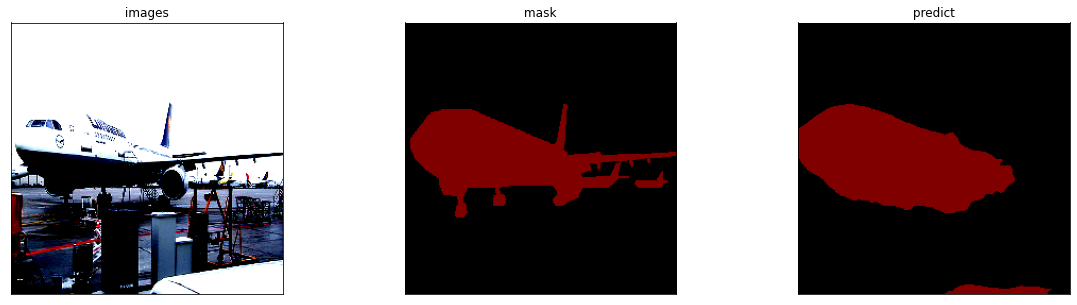

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0 19]
predict_color_index:[ 0 19]
(256, 256, 3)
(256, 256, 3)


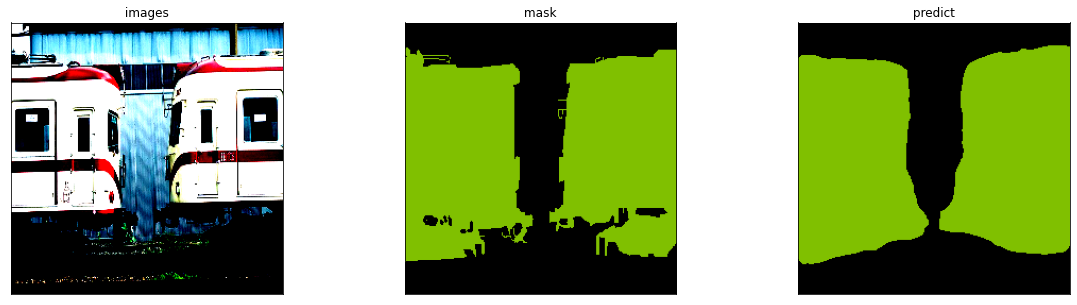

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[0 4]
predict_color_index:[ 0  5 11 13 15 18 19]
(256, 256, 3)
(256, 256, 3)


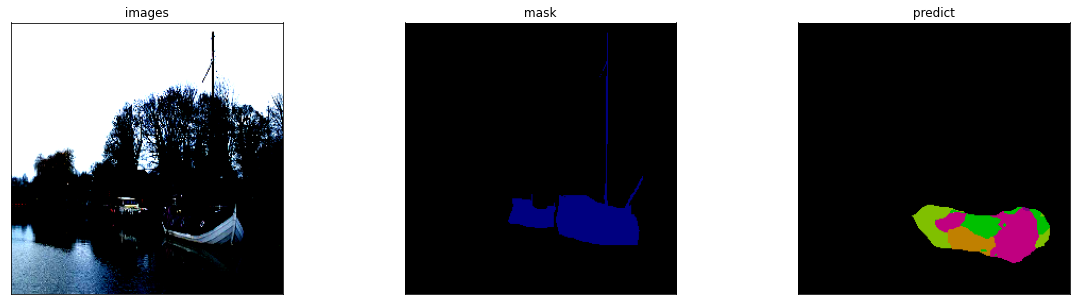

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0 19]
predict_color_index:[ 0  8 19]
(256, 256, 3)
(256, 256, 3)


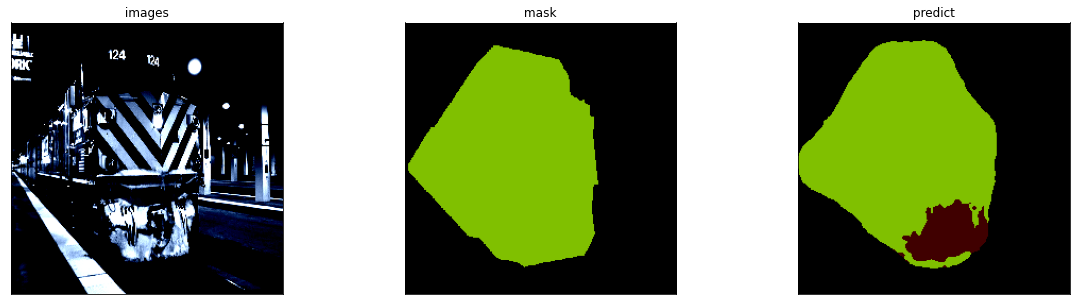

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0  2 15]
predict_color_index:[ 0 14 15]
(256, 256, 3)
(256, 256, 3)


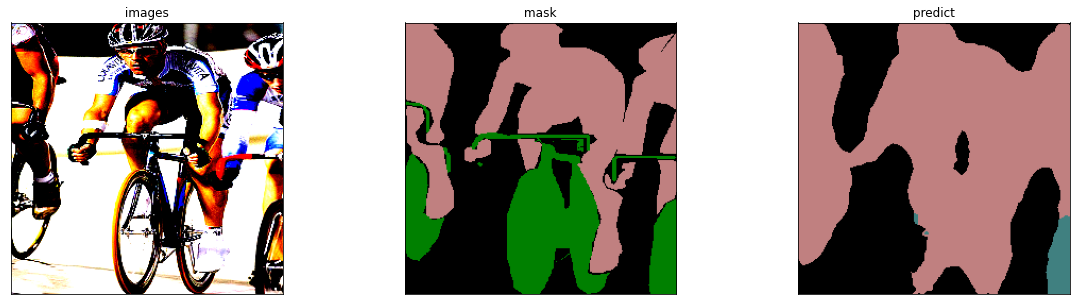

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0 17]
predict_color_index:[ 0 17]
(256, 256, 3)
(256, 256, 3)


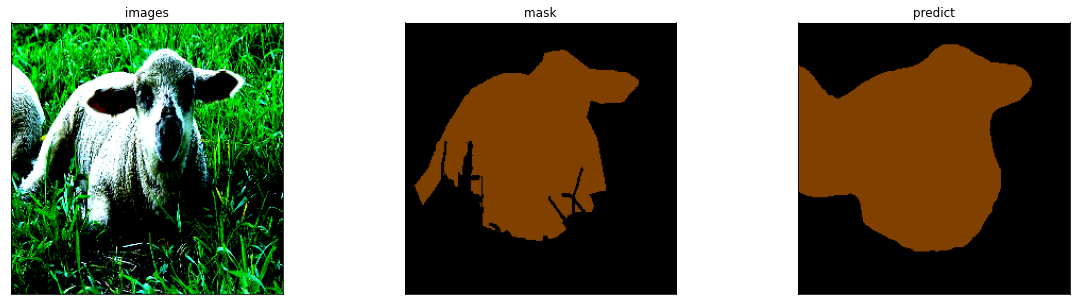

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0 20]
predict_color_index:[ 0 20]


(256, 256, 3)
(256, 256, 3)


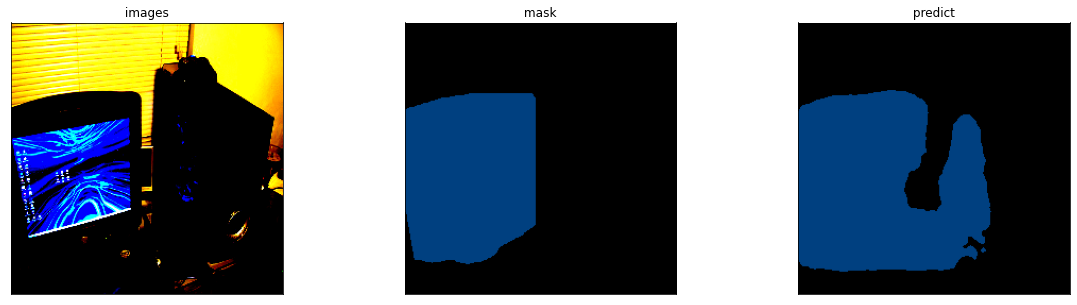

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0 15]
predict_color_index:[ 0 15]
(256, 256, 3)
(256, 256, 3)


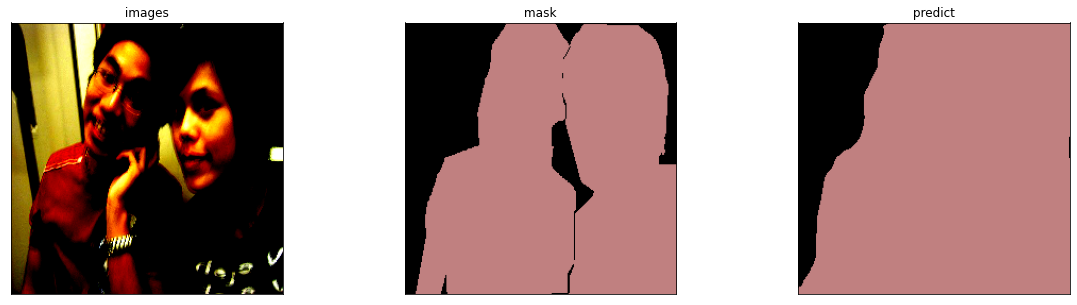

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0 13]
predict_color_index:[ 0  7 12 13 17 18]
(256, 256, 3)
(256, 256, 3)


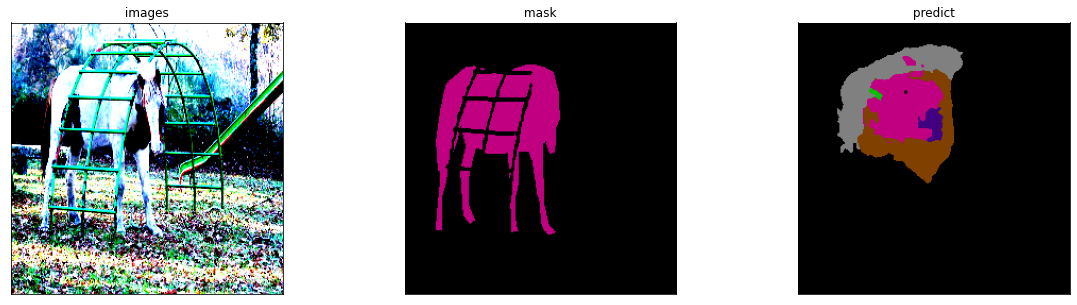

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0  5 15]
predict_color_index:[ 0  5 15]
(256, 256, 3)
(256, 256, 3)


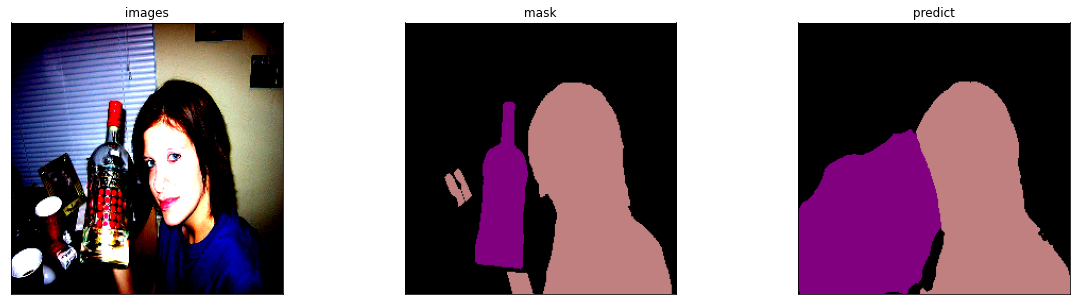

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0  9 18]
predict_color_index:[ 0 18]
(256, 256, 3)
(256, 256, 3)


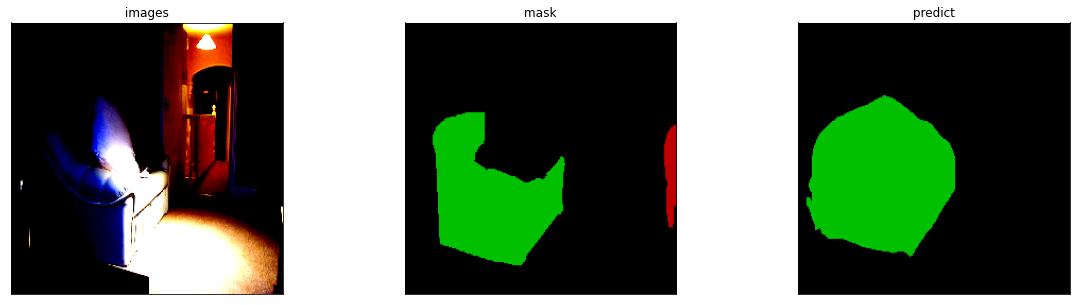

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0 10]
predict_color_index:[ 0 13]


(256, 256, 3)
(256, 256, 3)


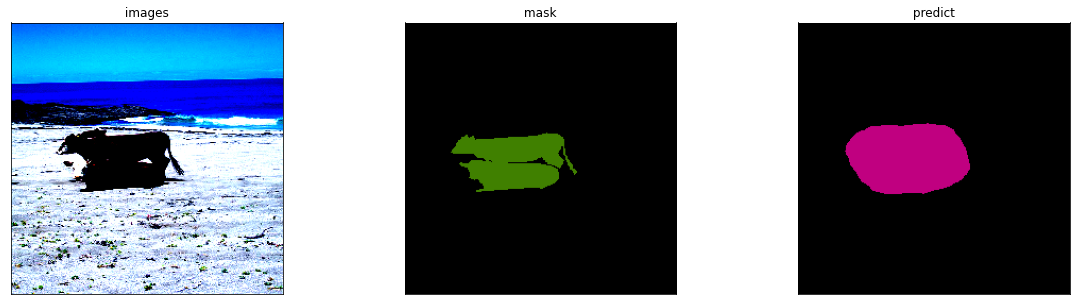

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0 10]
predict_color_index:[ 0 13 14]
(256, 256, 3)
(256, 256, 3)


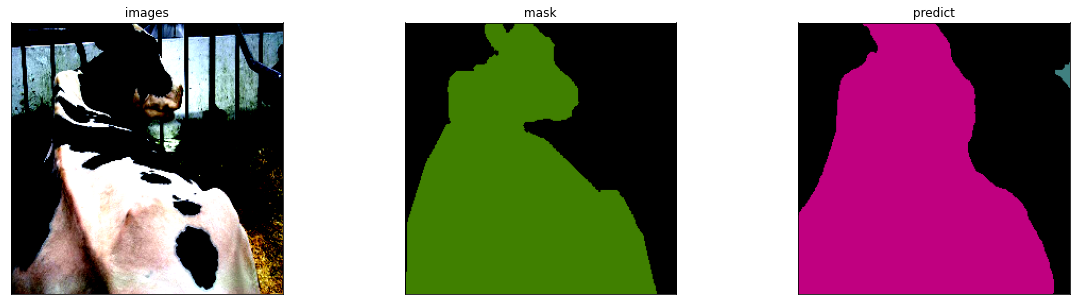

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[0 4 7]
predict_color_index:[ 0  1  7 15]
(256, 256, 3)
(256, 256, 3)


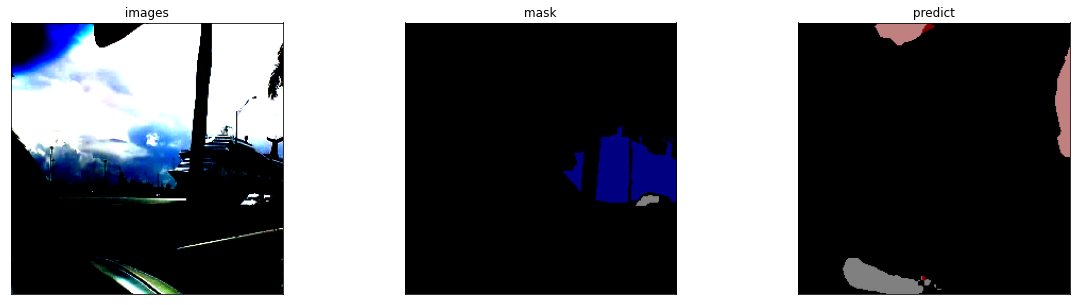

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0  5 20]
predict_color_index:[ 0 15 20]
(256, 256, 3)
(256, 256, 3)


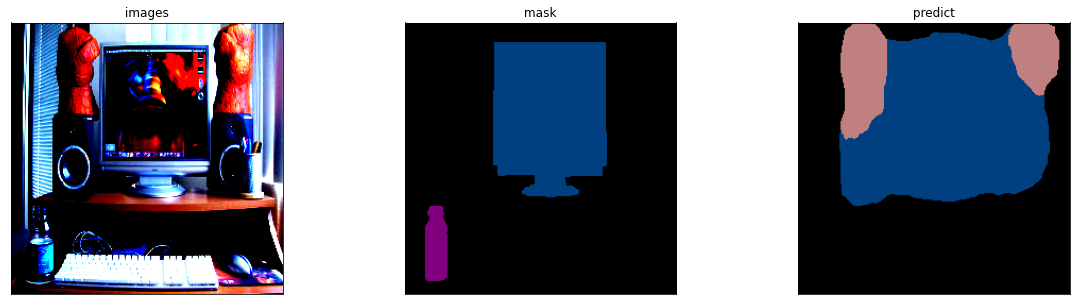

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[0 2]
predict_color_index:[ 0 14 19]
(256, 256, 3)
(256, 256, 3)


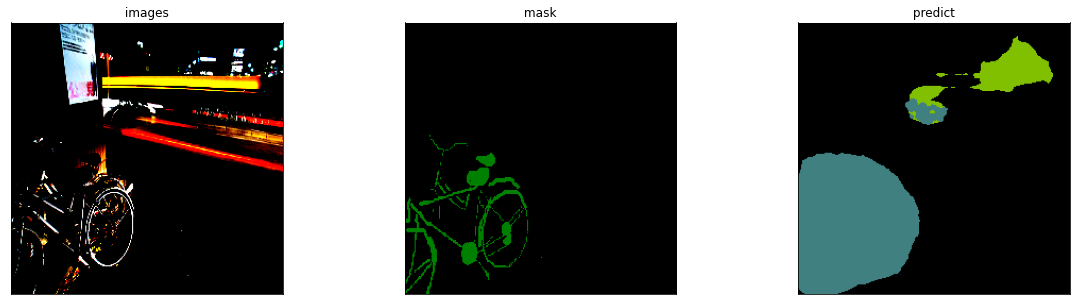

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0 15 19]
predict_color_index:[ 0  6 19]
(256, 256, 3)
(256, 256, 3)


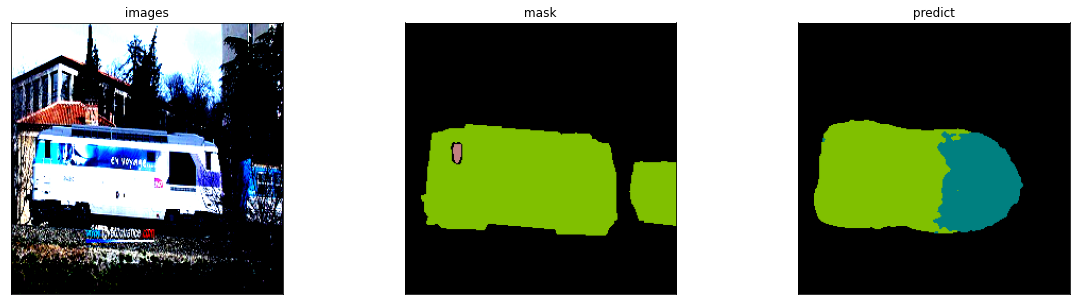

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0 19]
predict_color_index:[ 0 19]


(256, 256, 3)
(256, 256, 3)


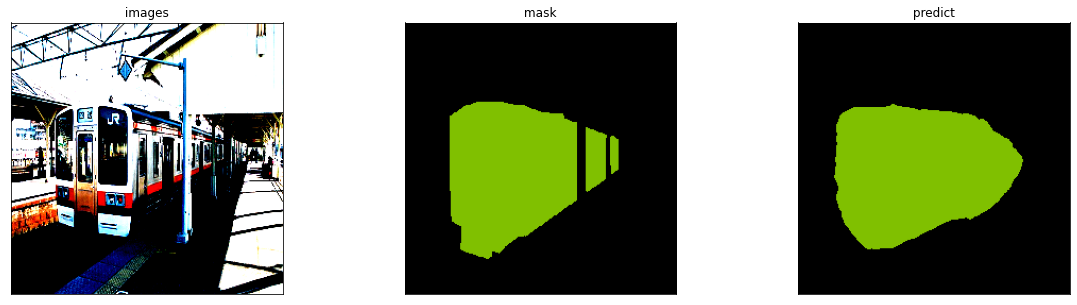

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0  9 16 18]
predict_color_index:[ 0 18]
(256, 256, 3)
(256, 256, 3)


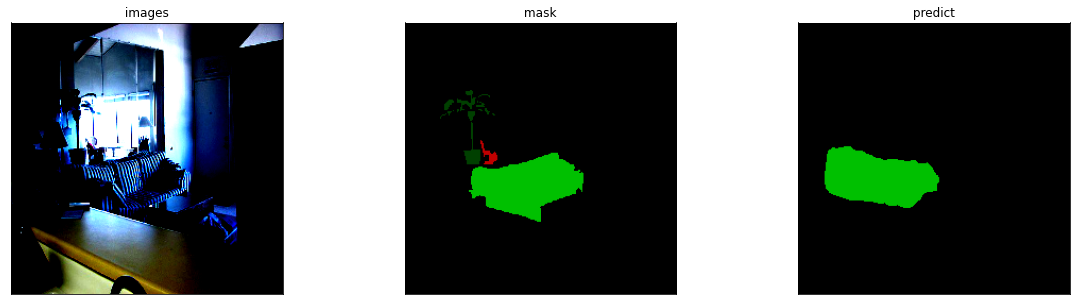

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[0 6 7]
predict_color_index:[0 6]
(256, 256, 3)
(256, 256, 3)


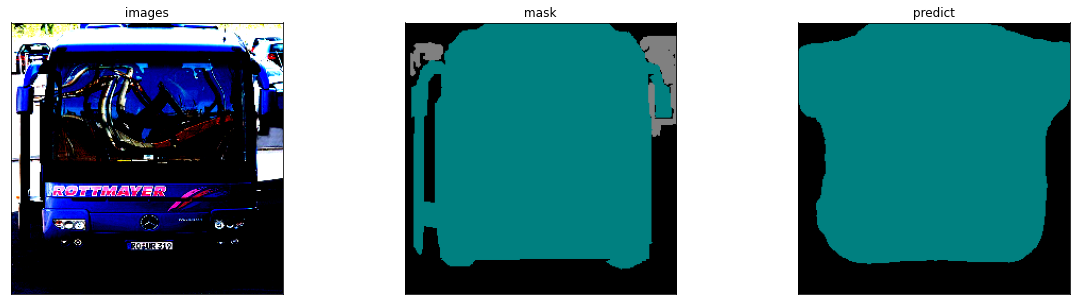

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0 17]
predict_color_index:[ 0 17]
(256, 256, 3)
(256, 256, 3)


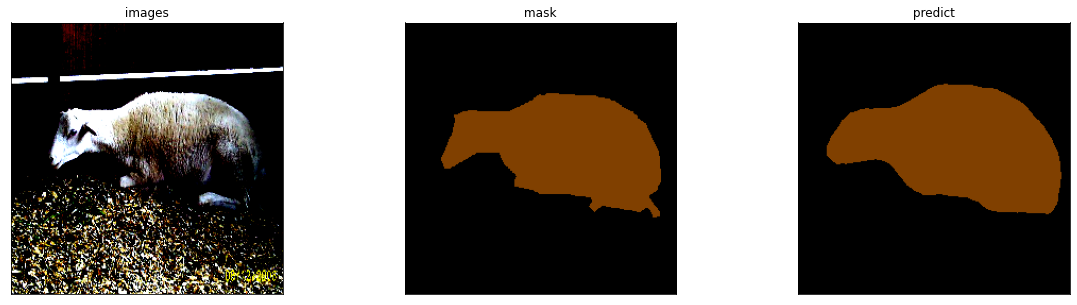

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0  6  7 15]
predict_color_index:[ 0  6 15 20]


(256, 256, 3)
(256, 256, 3)


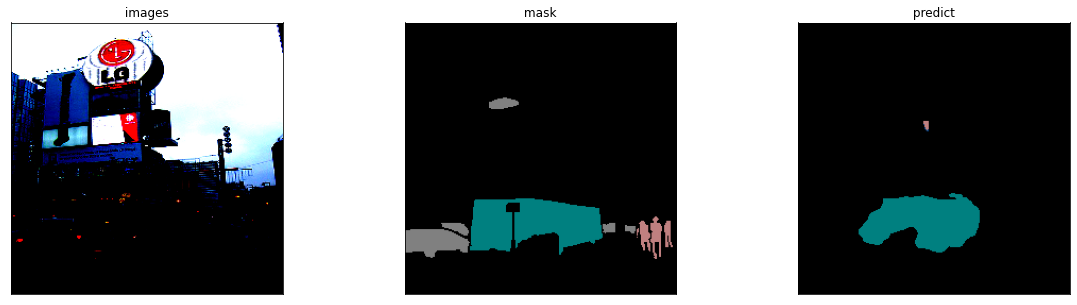

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0  5 11 15]
predict_color_index:[ 0  5 11 15]
(256, 256, 3)
(256, 256, 3)


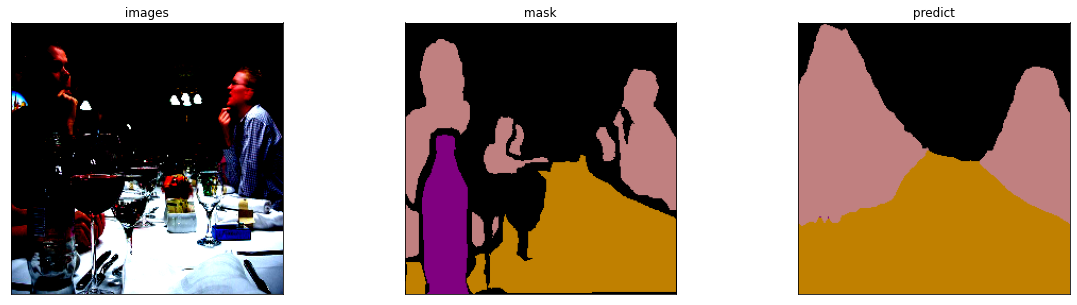

--------------------------------------------------------
--------------------------------------------------------


correct_color_index:[ 0 13 15]
predict_color_index:[ 0  1  7 13 14 15 17]
(256, 256, 3)
(256, 256, 3)


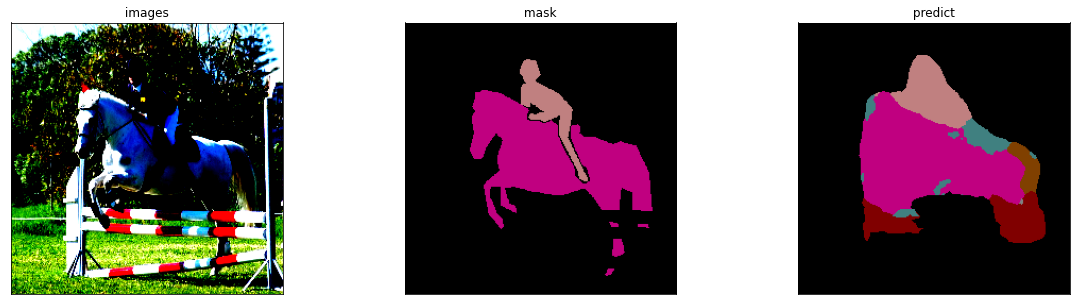

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0 13 15]
predict_color_index:[ 0 12 13 15]


(256, 256, 3)
(256, 256, 3)


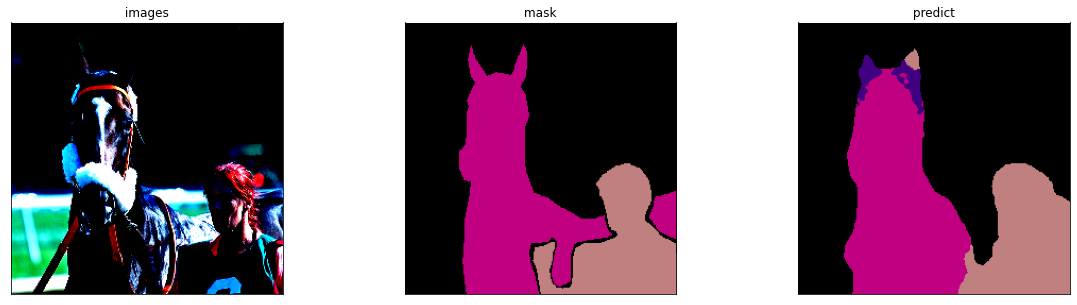

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0  9 18]
predict_color_index:[ 0 18]
(256, 256, 3)
(256, 256, 3)


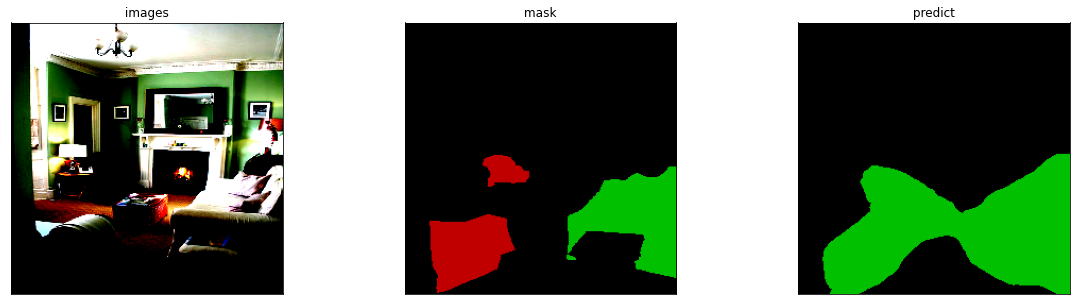

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0  9 11]
predict_color_index:[ 0 11]
(256, 256, 3)
(256, 256, 3)


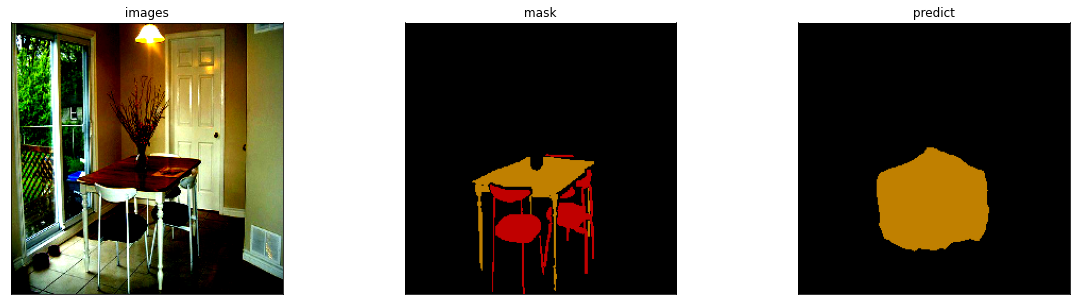

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[0 4]
predict_color_index:[0 1]
(256, 256, 3)
(256, 256, 3)


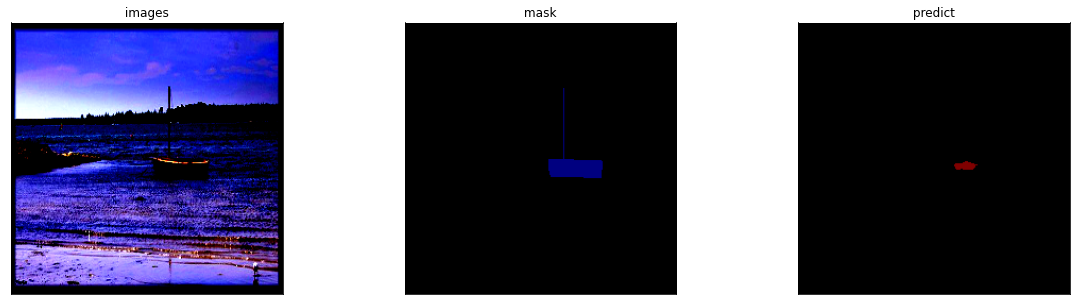

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0 11 15]
predict_color_index:[ 0  7 11 15 18]
(256, 256, 3)
(256, 256, 3)


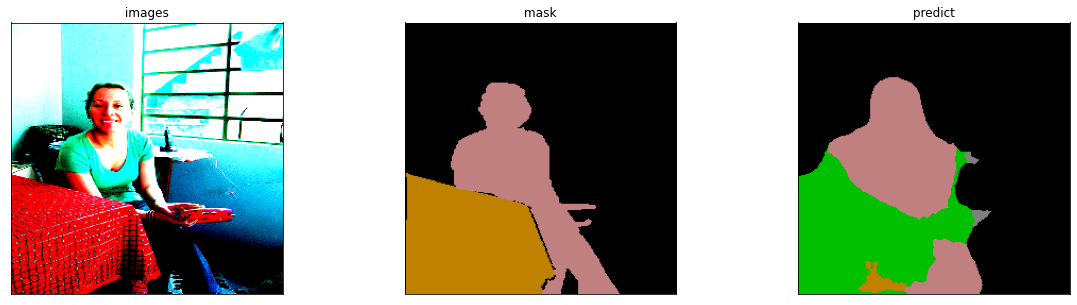

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0  4 15]
predict_color_index:[0 1]
(256, 256, 3)
(256, 256, 3)


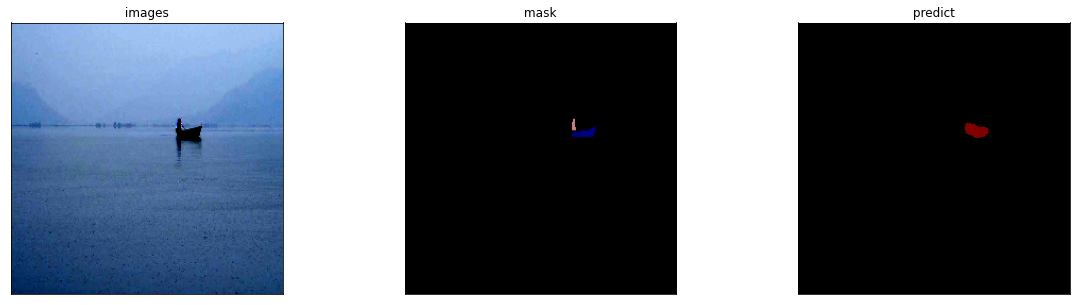

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0 17]
predict_color_index:[ 0 17]
(256, 256, 3)
(256, 256, 3)


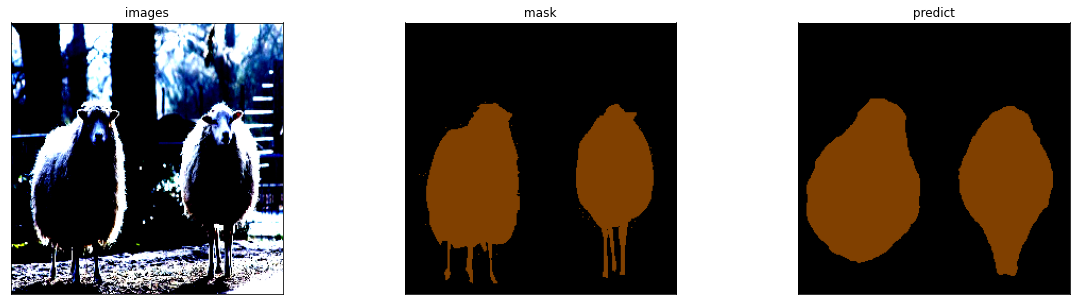

--------------------------------------------------------
--------------------------------------------------------
correct_color_index:[ 0  5 15]
predict_color_index:[ 0 15]


(256, 256, 3)
(256, 256, 3)


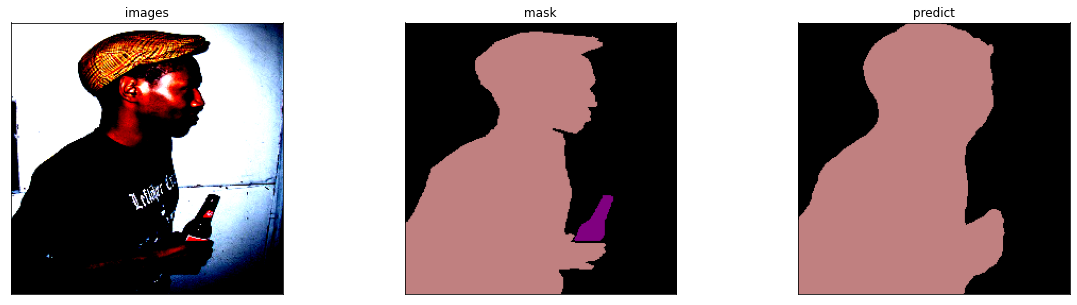

--------------------------------------------------------
--------------------------------------------------------


In [ ]:
for i , (images, label) in enumerate(valid_loader):
  batch_size=images.shape[0]
  predict_model.eval()
  predict = predict_model(images.to(DEVICE))

  
  #今回は1バッチのみplotしてみる
  for j in range(predict.shape[0]):

    reshape_label = torch.argmax(label[j],axis=0)

    tmp = torch.argmax(predict[j],axis=0)
    
    reshape_tmp = tmp.cpu()
    print("correct_color_index:{}".format(np.unique(np.asarray(reshape_label.reshape(-1)))))
    print("predict_color_index:{}".format(np.unique(np.asarray(reshape_tmp.reshape(-1)))))

    #バッチサイズの中身毎に描画
    visualize(
      image=images[j].transpose(2,0), 
      mask=label[j].cpu().transpose(2,0).detach().numpy(),
      predict_mask = predict[j].cpu().transpose(2,0).detach().numpy()
    )
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
  break